In [ ]:
!pip -q install pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF version:", tf.__version__)
tf.random.set_seed(42)
np.random.seed(42)

TF version: 2.19.0


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# CNN expects (28,28,1)
x_train_cnn = np.expand_dims(x_train, -1)
x_test_cnn  = np.expand_dims(x_test, -1)

VAL_SPLIT = 0.1

print("Train shape:", x_train_cnn.shape)
print("Test shape :", x_test_cnn.shape)

Train shape: (60000, 28, 28, 1)
Test shape : (10000, 28, 28, 1)


In [ ]:
def build_cnn(activation="relu", use_bn=False, dropout_rate=0.25):
    inputs = keras.Input(shape=(28, 28, 1))

    x = layers.Conv2D(32, (3,3), padding="same")(inputs)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv2D(64, (3,3), padding="same")(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.MaxPooling2D((2,2))(x)

    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(128)(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    outputs = layers.Dense(10, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
def make_optimizer(name, lr=0.01):
    name = name.lower()
    if name == "sgd":
        return keras.optimizers.SGD(learning_rate=lr)
    if name in ["sgd_momentum", "momentum"]:
        return keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    if name == "adam":
        return keras.optimizers.Adam(learning_rate=lr)

In [ ]:
def run_experiment(exp_name, activation, optimizer_name, epochs,
                   use_bn=False, dropout_rate=0.25, lr=0.01):

    model = build_cnn(activation, use_bn, dropout_rate)
    optimizer = make_optimizer(optimizer_name, lr)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history = model.fit(
        x_train_cnn, y_train,
        epochs=epochs,
        batch_size=128,
        validation_split=VAL_SPLIT,
        verbose=1
    )

    test_loss, test_acc = model.evaluate(x_test_cnn, y_test, verbose=0)

    return {
        "Experiment": exp_name,
        "Activation": activation,
        "Optimizer": optimizer_name,
        "Final_Test_Accuracy": test_acc,
        "history": history.history
    }

In [ ]:
experiments = [
    {"exp_name":"Sigmoid + SGD", "activation":"sigmoid", "optimizer":"sgd", "epochs":10, "lr":0.05},
    {"exp_name":"ReLU + SGD",    "activation":"relu",    "optimizer":"sgd", "epochs":10, "lr":0.05},
    {"exp_name":"ReLU + Adam",   "activation":"relu",    "optimizer":"adam","epochs":10, "lr":0.001},
]

In [ ]:
results = []

for exp in experiments:
    print("\nRunning:", exp["exp_name"])
    res = run_experiment(
        exp["exp_name"],
        exp["activation"],
        exp["optimizer"],
        exp["epochs"],
        lr=exp["lr"]
    )
    results.append(res)


Running: Sigmoid + SGD
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 195s 460ms/step - accuracy: 0.1041 - loss: 2.3260 - val_accuracy: 0.0978 - val_loss: 2.3056
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 193s 457ms/step - accuracy: 0.1076 - loss: 2.3053 - val_accuracy: 0.0978 - val_loss: 2.3050
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 196s 443ms/step - accuracy: 0.1101 - loss: 2.3053 - val_accuracy: 0.0978 - val_loss: 2.3050
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 188s 446ms/step - accuracy: 0.1089 - loss: 2.3050 - val_accuracy: 0.0978 - val_loss: 2.3049
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 189s 448ms/step - accuracy: 0.1098 - loss: 2.3048 - val_accuracy: 0.0978 - val_loss: 2.3048
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 204s 453ms/step - accuracy: 0.1089 - loss: 2.3046 - val_accuracy: 0.0978 - val_loss: 2.3046
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 198s 443ms/step - accuracy: 0.1101 - loss: 2.3043 - val_accuracy: 0.0978 - val_loss: 2.3042
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 187s 443ms/s

In [ ]:
table = pd.DataFrame({
    "Activation + Optimizer": [r["Experiment"] for r in results],
    "Final Test Accuracy": [r["Final_Test_Accuracy"] for r in results]
})

display(table)

,Activation + Optimizer,Final Test Accuracy
0,Sigmoid + SGD,0.8064
1,ReLU + SGD,0.9859
2,ReLU + Adam,0.9891


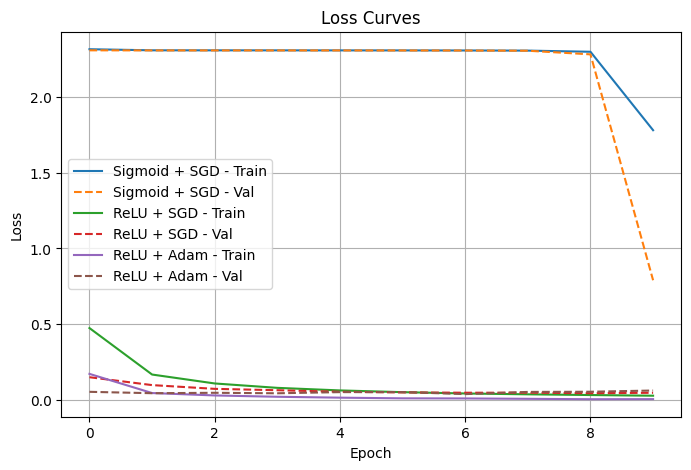

In [ ]:
plt.figure(figsize=(8,5))

for r in results:
    plt.plot(r["history"]["loss"], label=f'{r["Experiment"]} - Train')
    plt.plot(r["history"]["val_loss"], linestyle="--", label=f'{r["Experiment"]} - Val')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

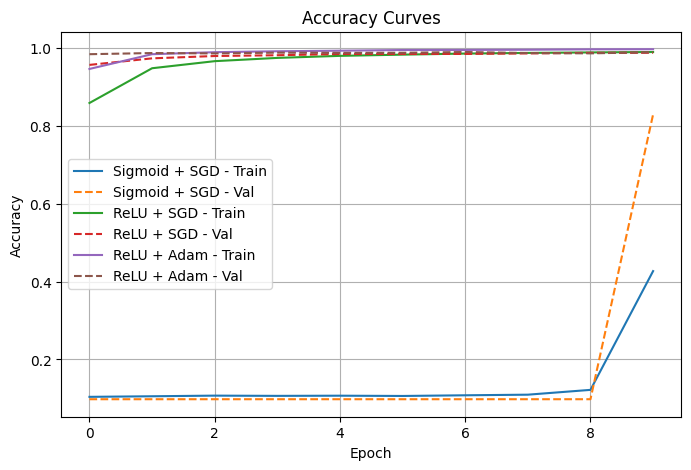

In [ ]:
plt.figure(figsize=(8,5))

for r in results:
    plt.plot(r["history"]["accuracy"], label=f'{r["Experiment"]} - Train')
    plt.plot(r["history"]["val_accuracy"], linestyle="--", label=f'{r["Experiment"]} - Val')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()